In [1]:
import tensorflow as tf
import numpy as np
import time
import os
import PIL
import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import imageio
from IPython import display
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(tf.__version__)
tf.test.is_gpu_available()


2.0.0-rc1


True

In [17]:
# Reshape to account for greyscales and normalize RGB to [-1,1] as per GoodFellow 2016
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5)/127.5

In [18]:
img_size = 28*28
noise_size = 100
batch_size = 128
buffer_size = 60000

In [19]:
# Shuffle the dataset
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [20]:
# Generates a tensor sampled from a random normal distribution
def generate_uniform_noise(batch_size, dimensions) :
    return tf.random.normal([batch_size, dimensions],dtype=tf.dtypes.float32)

In [21]:
# Generator Model definition = DENSE -> BN + ReLU -> DECONV -> BN + ReLU -> DECONV
def create_generator_model() :
    model = tf.keras.Sequential()
    
    #First layer of generator - FC
    model.add(layers.Dense(7*7*256, input_shape=(noise_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,256)));
    
    # Second layer of generator - CONV
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same'))       # We need to perform deconvolution here
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third layer of generator - CONV
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))       # We need to perform deconvolution here
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # use tanh activation in last 
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model
    

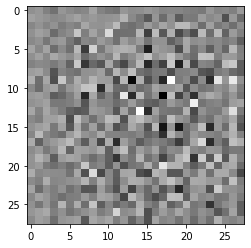

In [22]:
generator = create_generator_model()
noise = generate_uniform_noise(1, noise_size)
generated_img = generator(noise, training=False)
plt.imshow(generated_img[0, :, :, 0], cmap='gray')
plt.show()



In [23]:
# Discriminator Model definition = CONV2D -> BN + ReLU + Dropout -> CONV2D -> BN + ReLU + Dropout -> FLATTEN -> DENSE -> BINARY OUTPUT
def create_discriminator_model() :
    model = tf.keras.Sequential()
    
    # First layer
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second layer
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #Final output
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [24]:
discriminator = create_discriminator_model()
decison = discriminator(generated_img)
    

In [25]:
# Define loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)


In [26]:
# Loss for discriminator
def discriminator_loss(output_orig, output_gen) :
    loss_orig = loss(tf.ones_like(output_orig), output_orig)
    loss_gen = loss(tf.zeros_like(output_gen), output_gen)
    return loss_orig + loss_gen
    

In [27]:
# Loss for generator
def generator_loss(output_gen) :
    return loss(tf.ones_like(output_gen), output_gen)


In [28]:
# Optimizers
discr_optimizer = tf.keras.optimizers.Adam(1e-4)
genr_optimizer = tf.keras.optimizers.Adam(1e-4)


In [30]:
# Creating checkpoints for the model
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(genr_optimizer=genr_optimizer,
                                 discr_optimizer=discr_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
# Training the networks

NUM_EPOCHS = 100
NUM_EXAMPLES = 16
random_fixed_noise = generate_uniform_noise(NUM_EXAMPLES, noise_size)
global loss_g 
global loss_d 


def train_one_step(images_mini_batch) :
    noise = generate_uniform_noise(batch_size, noise_size)
    with tf.GradientTape() as discr_gradient, tf.GradientTape() as genr_gradient :
        generated_images = generator(noise, training=True)
        output_real = discriminator(images_mini_batch, training=True)
        output_fake = discriminator(generated_images, training=True)
        
        discr_loss = discriminator_loss(output_real, output_fake)
        gen_loss = generator_loss(output_fake)
        
        
    genr_gradients = genr_gradient.gradient(gen_loss, generator.trainable_variables)
    discr_gradients = discr_gradient.gradient(discr_loss, discriminator.trainable_variables)
    
    genr_optimizer.apply_gradients(zip(genr_gradients, generator.trainable_variables))
    discr_optimizer.apply_gradients(zip(discr_gradients, discriminator.trainable_variables))
    loss_d = discr_loss
    loss_g = gen_loss


In [35]:
def generate_img(model, test_input, epoch) :
    predictions=model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig("img_at_epoch_{}.png".format(epoch))
    plt.show()
    

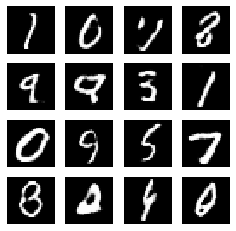

In [36]:
def train(dataset, epochs) :
    for t in range(epochs):
        start = time.time()
        for images in dataset :
            train_one_step(images)
        display.clear_output(wait=True)
        generate_img(generator, random_fixed_noise, t)
        
    #Final epoch
    display.clear_output(wait=True)
    generate_img(generator, random_fixed_noise, epochs)
    
train(x_train, NUM_EPOCHS)
        
            
            

In [43]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{}.png'.format(epoch_no))

display_image(NUM_EPOCHS-2)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_98.png'

In [38]:
gif_file = 'mnist_generation.gif'
with imageio.get_writer(gif_file, mode='I') as writer :
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames) :
        frame = 2*(i**0.5)
        if(round(frame) > round(last)) :
            last = frame
        else :
            continue
        image = imageio.imread(filename)
        writer.append_data(image)

display.image(filename=gif_file)


NameError: name 'glob' is not defined